## Assignment 2.3: Text classification via RNN (30 points)

In this assignment you will perform sentiment analysis of the IMDBs reviews by using RNN. An additional goal is to learn high abstactions of the **torchtext** module that consists of data processing utilities and popular datasets for natural language.

In [1]:
import pandas as pd
import numpy as np
import torch

from torchtext import datasets

from torchtext.data import Field, LabelField
from torchtext.data import BucketIterator

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import spacy
import re
import pickle
import matplotlib.pyplot as plt

In [2]:
def set_random_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.cuda.manual_seed(seed)
    torch.manual_seed(seed)

set_random_seed(42)

In [3]:
device = 'cuda'

### Preparing Data

In [4]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'tagger', 'ner'])

In [5]:
def text_cleaner(text):
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
    return text.strip()

def tokenizer(s): 
    return [w.text.lower() for w in nlp(text_cleaner(s))]

In [6]:
TEXT = Field(sequential=True, tokenize=tokenizer, include_lengths=True)
LABEL = LabelField(dtype=torch.float)

In [7]:
train, tst = datasets.IMDB.splits(TEXT, LABEL)
trn, vld = train.split()

In [8]:
from torchtext import vocab

In [9]:
vec = vocab.Vectors('wiki.en.align.vec', './data')

In [10]:
%%time
TEXT.build_vocab(trn, vld, vectors=vec)

Wall time: 1.52 s


In [11]:
print(TEXT.vocab.vectors.shape)

torch.Size([74407, 300])


In [12]:
TEXT.vocab.vectors[TEXT.vocab.stoi['word']]

tensor([-6.8400e-02,  1.6300e-02, -3.0000e-03,  3.9500e-02, -2.3600e-02,
         9.0000e-03, -1.1410e-01, -7.7000e-02,  1.0640e-01, -5.5200e-02,
        -1.0000e-04,  1.1600e-02, -1.5200e-02, -1.8200e-02, -1.6900e-02,
        -2.3700e-02,  7.0000e-03,  2.3500e-02,  7.1500e-02,  7.9600e-02,
        -2.8600e-02,  5.8000e-03,  2.6700e-02, -4.1100e-02, -3.2900e-02,
         4.7100e-02,  3.5400e-02, -3.4800e-02, -3.9400e-02, -7.9000e-03,
        -4.9200e-02,  6.4300e-02, -5.6500e-02,  2.5700e-02, -1.6900e-02,
        -4.8000e-02,  6.3000e-02, -6.6000e-03,  4.6400e-02,  5.2300e-02,
         5.5300e-02,  1.3300e-02, -9.2000e-03, -2.8400e-02, -4.0000e-02,
         1.5900e-02,  2.2600e-02, -1.0540e-01, -2.1000e-02, -4.3100e-02,
         2.0900e-02, -3.0000e-03,  6.7500e-02, -1.8400e-02, -8.9200e-02,
        -2.9000e-02, -1.8100e-02,  2.9000e-03,  6.6300e-02,  6.9000e-03,
         5.9000e-02,  4.2600e-02, -2.7600e-02,  1.9400e-02, -7.7000e-03,
        -1.2500e-02,  6.6900e-02,  4.8900e-02,  2.1

In [13]:
LABEL.build_vocab(trn)

The vocab.freqs is a collections.Counter object, so we can take a look at the most frequent words.

In [14]:
len(TEXT.vocab), len(LABEL.vocab)

(74407, 2)

In [15]:
TEXT.vocab.freqs.most_common(10)

[('the', 336758),
 ('and', 164141),
 ('a', 163159),
 ('of', 145865),
 ('to', 135724),
 ('is', 107349),
 ('br', 101872),
 ('it', 96474),
 ('in', 93981),
 ('i', 87855)]

In [16]:
LABEL.vocab.freqs.most_common()

[('pos', 8760), ('neg', 8740)]

In [18]:
# from gensim.models import KeyedVectors

In [19]:
# try:
#     with open('data/wiki.en.align.pkl', 'rb') as f:
#         ft_en = pickle.load(f)
# except:
#     ft = KeyedVectors.load_word2vec_format('data/wiki.en.align.vec')
#     ft_en = ft.get_vector
#     with open('data/wiki.en.align.pkl', 'wb') as f:
#         pickle.dump(ft_en, f)

In [20]:
# a = []
# for i, z in LABEL.vocab:
#     print(i, z)
#     break

### Creating the Iterator (2 points)

During training, we'll be using a special kind of Iterator, called the **BucketIterator**. When we pass data into a neural network, we want the data to be padded to be the same length so that we can process them in batch:

e.g.
\[ 
\[3, 15, 2, 7\],
\[4, 1\], 
\[5, 5, 6, 8, 1\] 
\] -> \[ 
\[3, 15, 2, 7, **0**\],
\[4, 1, **0**, **0**, **0**\], 
\[5, 5, 6, 8, 1\] 
\] 

If the sequences differ greatly in length, the padding will consume a lot of wasteful memory and time. The BucketIterator groups sequences of similar lengths together for each batch to minimize padding.

Complete the definition of the **BucketIterator** object

In [17]:
next(trn.text)[:20]

['i',
 'm',
 'sorry',
 'but',
 'this',
 'is',
 'just',
 'awful',
 'i',
 'have',
 'told',
 'people',
 'about',
 'this',
 'film',
 'and',
 'some',
 'of',
 'the',
 'bad']

In [18]:
train_iter, val_iter, test_iter = BucketIterator.splits(
        (trn, vld, tst),
        batch_sizes=(32, 32, 32),
        sort_key= lambda x: len(x.text),
        sort_within_batch=True,
        device=device,
        repeat=False,
)

Let's take a look at what the output of the BucketIterator looks like. Do not be suprised **batch_first=True**

In [19]:
batch = next(train_iter.__iter__()); batch.text

(tensor([[   11, 13366,    12,  ...,  2098,    16,   944],
         [  139,    12,    21,  ...,  1586,   110, 11451],
         [ 1587,    21,    15,  ...,   518,  1967,    14],
         ...,
         [   15,    10,  1989,  ...,     1,     1,     1],
         [  181,    12,     8,  ...,     1,     1,     1],
         [  678,    19,     8,  ...,     1,     1,     1]], device='cuda:0'),
 tensor([303, 303, 303, 303, 302, 302, 302, 302, 302, 302, 301, 301, 301, 301,
         301, 301, 300, 300, 300, 300, 300, 299, 299, 299, 298, 298, 298, 298,
         298, 297, 297, 297], device='cuda:0'))

The batch has all the fields we passed to the Dataset as attributes. The batch data can be accessed through the attribute with the same name.

In [20]:
batch.text[1]

tensor([303, 303, 303, 303, 302, 302, 302, 302, 302, 302, 301, 301, 301, 301,
        301, 301, 300, 300, 300, 300, 300, 299, 299, 299, 298, 298, 298, 298,
        298, 297, 297, 297], device='cuda:0')

In [21]:
batch.text[0].size()

torch.Size([303, 32])

In [22]:
batch.label

tensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
        1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1.],
       device='cuda:0')

In [23]:
batch.__dict__.keys()

dict_keys(['batch_size', 'dataset', 'fields', 'input_fields', 'target_fields', 'text', 'label'])

### Define the RNN-based text classification model (10 points)

Start simple first. Implement the model according to the shema below.  
![alt text](https://miro.medium.com/max/1396/1*v-tLYQCsni550A-hznS0mw.jpeg)


In [24]:
vocab_size = len(TEXT.vocab)

In [25]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [105]:
def evaluate_model(model, batch_iter):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    TOTAL = 0
    for batch in batch_iter:
        x, lens = batch.text
        y = batch.label
        y_hat = torch.sigmoid(model(x, lens))
        TP += torch.sum(y_hat[y == 1] >= 0.5).item()
        FP += torch.sum(y_hat[y == 0] >= 0.5).item()
        TN += torch.sum(y_hat[y == 0] < 0.5).item()
        FN += torch.sum(y_hat[y == 1] < 0.5).item()
        TOTAL += len(y)
    accuracy = (TP + TN) / TOTAL
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 / (1/precision + 1/recall)
    return accuracy, precision, recall, f1

def print_eval_results(accuracy, precision, recall, f1):
    print(f'accuracy = {accuracy}')
    print(f'precision = {precision}')
    print(f'recall = {recall}')
    print(f'f1 = {f1}')

### Experiments (10 points)

Experiment with the model and achieve better results. You can find advices [here](https://arxiv.org/abs/1801.06146). Implement and describe your experiments in details, mention what was helpful.

### 1. RNN with freezed fasttext embeddings

In [112]:
class RNNB_with_fasttext(nn.Module):
    def __init__(self, hidden_dim, emb_dim, vocab_size, pretrained_vecs):
        super(RNNB_with_fasttext, self).__init__()
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim
        self.vocab_size = vocab_size
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=1)
        self.embed.weight.data.copy_(pretrained_vecs)
        self.embed.weight.requires_grad = False
        self.gru = nn.GRU(emb_dim, hidden_dim, batch_first=False)
        self.fc = nn.Linear(hidden_dim, 1)
            
    def forward(self, seq, lens):
        embeds = self.embed(seq)
        embeds = pack_padded_sequence(embeds, lens)
        gru_out, h = self.gru(embeds)
        preds = self.fc(h).view(-1)
        return preds

In [139]:
em_sz = 300
nh = 300
model_with_ft = RNNB_with_fasttext(nh, emb_dim=em_sz, vocab_size=vocab_size, 
                    pretrained_vecs=TEXT.vocab.vectors).to(device)

In [140]:
model_with_ft

RNNB_with_fasttext(
  (embed): Embedding(74407, 300, padding_idx=1)
  (gru): GRU(300, 300)
  (fc): Linear(in_features=300, out_features=1, bias=True)
)

In [141]:
model_with_ft.cuda()

RNNB_with_fasttext(
  (embed): Embedding(74407, 300, padding_idx=1)
  (gru): GRU(300, 300)
  (fc): Linear(in_features=300, out_features=1, bias=True)
)

In [142]:
opt = optim.Adam(filter(lambda p: p.requires_grad, model_with_ft.parameters()), lr=1e-3)
loss_func = nn.BCEWithLogitsLoss()

In [143]:
epochs = 8
train_losses = [] 
val_losses = []

In [144]:
%%time
with torch.autograd.set_detect_anomaly(True):
    for epoch in range(1, epochs + 1):
        running_loss = 0.0
        running_corrects = 0
        model_with_ft.train() 
        for i, batch in enumerate(train_iter): 
            x, lens = batch.text
            y = batch.label
            opt.zero_grad()
            preds = model_with_ft(x, lens)
            loss = loss_func(preds, y)
            loss.backward()
            opt.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_iter)
        train_losses.append(epoch_loss)

        val_loss = 0.0
        model_with_ft.eval()
        for j, batch in enumerate(val_iter):
            with torch.no_grad():
                x, lens = batch.text
                y = batch.label
                preds = model_with_ft(x, lens) 
                loss = loss_func(preds, y)
                val_loss += loss.item()

        val_loss /= len(val_iter)
        val_losses.append(val_loss)
        print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(epoch, epoch_loss, val_loss))

Epoch: 1, Training Loss: 0.6163450338395902, Validation Loss: 0.3914361259404649
Epoch: 2, Training Loss: 0.3532551243165729, Validation Loss: 0.30802246186327426
Epoch: 3, Training Loss: 0.29151465085895234, Validation Loss: 0.2849146946313533
Epoch: 4, Training Loss: 0.26773786897578666, Validation Loss: 0.29140718620508277
Epoch: 5, Training Loss: 0.2438537054771806, Validation Loss: 0.2751834032541894
Epoch: 6, Training Loss: 0.23128782223630867, Validation Loss: 0.26762453263744396
Epoch: 7, Training Loss: 0.20934435697289447, Validation Loss: 0.26684344127140147
Epoch: 8, Training Loss: 0.18788630558583047, Validation Loss: 0.27804637770069407
Wall time: 2min 34s


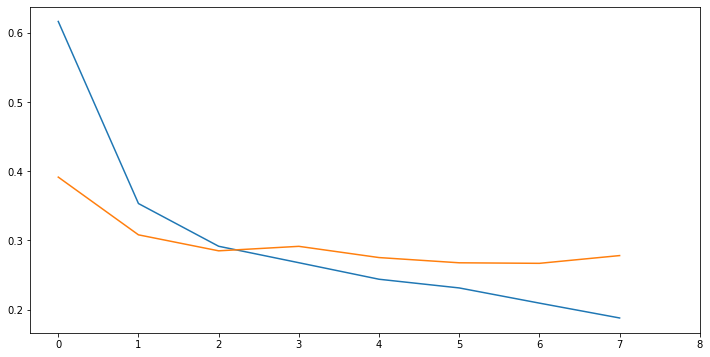

In [145]:
plt.figure(figsize=(12,6))
plt.plot(train_losses)
plt.plot(val_losses)
ticks = plt.xticks(range(epochs + 1))

In [146]:
accuracy, precision, recall, f1 = evaluate_model(model_with_ft, train_iter)

In [147]:
print_eval_results(accuracy, precision, recall, f1)

accuracy = 0.9472
precision = 0.9568985710939331
recall = 0.9362823745129498
f1 = 0.9464782205746063


In [148]:
accuracy, precision, recall, f1 = evaluate_model(model_with_ft, test_iter)

In [149]:
print_eval_results(accuracy, precision, recall, f1)

accuracy = 0.89308
precision = 0.9093559943347497
recall = 0.8732
f1 = 0.8909113169815942


Присутствует переобучение.

### 2. LSTM 2-layers + fully connected 2 layers + dropout

In [203]:
class RNNB_lstm_2l(nn.Module):
    def __init__(self, hidden_dim, emb_dim, vocab_size, pretrained_vecs, num_layers=2):
        super(RNNB_lstm_2l, self).__init__()
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=1)
        self.embed.weight.data.copy_(pretrained_vecs)
        self.embed.weight.requires_grad = False
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=False, 
                            num_layers=self.num_layers, dropout=0.5)
        self.fc_1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.5)
            
    def forward(self, seq, lens):
        embeds = self.embed(seq)
        embeds = pack_padded_sequence(embeds, lens)
        lstm_out, (h, c) = self.lstm(embeds)
        x = self.dropout(F.relu((self.fc_1(h[0]))))
        preds = self.fc_2(x).view(-1)
        return preds

In [215]:
em_sz = 300
nh = 300
model_lstm_2l = RNNB_lstm_2l(nh, emb_dim=em_sz, vocab_size=vocab_size, 
                    pretrained_vecs=TEXT.vocab.vectors).to(device)

In [216]:
model_lstm_2l

RNNB_lstm_2l(
  (embed): Embedding(74407, 300, padding_idx=1)
  (lstm): LSTM(300, 300, num_layers=2, dropout=0.5)
  (fc_1): Linear(in_features=300, out_features=300, bias=True)
  (fc_2): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [217]:
model_lstm_2l.cuda()

RNNB_lstm_2l(
  (embed): Embedding(74407, 300, padding_idx=1)
  (lstm): LSTM(300, 300, num_layers=2, dropout=0.5)
  (fc_1): Linear(in_features=300, out_features=300, bias=True)
  (fc_2): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [218]:
opt = optim.Adam(filter(lambda p: p.requires_grad, model_lstm_2l.parameters()), lr=1e-3)
loss_func = nn.BCEWithLogitsLoss()

In [219]:
epochs = 10
train_losses = [] 
val_losses = []

In [220]:
%%time
with torch.autograd.set_detect_anomaly(True):
    for epoch in range(1, epochs + 1):
        running_loss = 0.0
        running_corrects = 0
        model_lstm_2l.train() 
        for i, batch in enumerate(train_iter): 
            x, lens = batch.text
            y = batch.label

            opt.zero_grad()
            preds = model_lstm_2l(x, lens)
            loss = loss_func(preds, y)
            loss.backward()
            opt.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_iter)
        train_losses.append(epoch_loss)

        val_loss = 0.0
        model_lstm_2l.eval()
        for j, batch in enumerate(val_iter):
            with torch.no_grad():
                x, lens = batch.text
                y = batch.label

                preds = model_lstm_2l(x, lens) 
                loss = loss_func(preds, y)
                val_loss += loss.item()

        val_loss /= len(val_iter)
        val_losses.append(val_loss)
        print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(epoch, epoch_loss, val_loss))

Epoch: 1, Training Loss: 0.6817321137710725, Validation Loss: 0.6665233645033329
Epoch: 2, Training Loss: 0.6395041554131063, Validation Loss: 0.6448780523969772
Epoch: 3, Training Loss: 0.6416101796753446, Validation Loss: 0.49138374036930976
Epoch: 4, Training Loss: 0.5369910539504161, Validation Loss: 0.5656834721565247
Epoch: 5, Training Loss: 0.4518655747774532, Validation Loss: 0.415679635519677
Epoch: 6, Training Loss: 0.38632461401400664, Validation Loss: 0.3653774986241726
Epoch: 7, Training Loss: 0.3327577691627377, Validation Loss: 0.3190475223863378
Epoch: 8, Training Loss: 0.3072290660394611, Validation Loss: 0.30786867230496506
Epoch: 9, Training Loss: 0.29233190252477986, Validation Loss: 0.29233444507451767
Epoch: 10, Training Loss: 0.28426524227182, Validation Loss: 0.28391524115775496
Wall time: 5min 59s


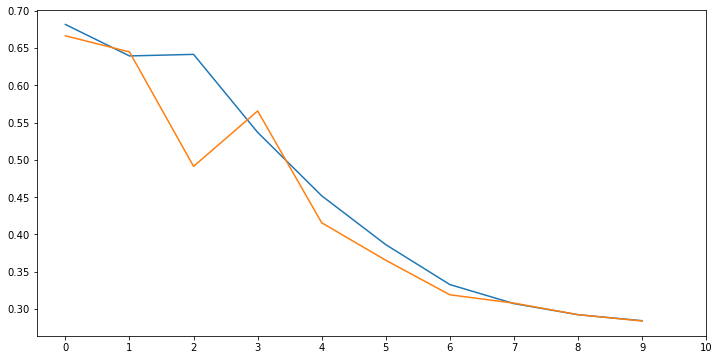

In [221]:
plt.figure(figsize=(12,6))
plt.plot(train_losses)
plt.plot(val_losses)
ticks = plt.xticks(range(epochs + 1))

In [222]:
accuracy, precision, recall, f1 = evaluate_model(model_lstm_2l, train_iter)

In [223]:
print_eval_results(accuracy, precision, recall, f1)

accuracy = 0.8976
precision = 0.8768478260869565
recall = 0.924478569791428
f1 = 0.9000334709360706


In [224]:
accuracy, precision, recall, f1 = evaluate_model(model_lstm_2l, test_iter)

In [225]:
print_eval_results(accuracy, precision, recall, f1)

accuracy = 0.88036
precision = 0.8638555138899517
recall = 0.90304
f1 = 0.88301325927954
